countouCenter:  228
countouCenter:  232
countouCenter:  236
countouCenter:  240
countouCenter:  245
countouCenter:  249


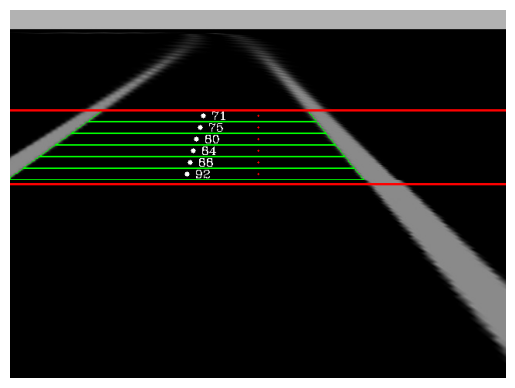

Pontos detectados:  [92, 88, 84, 80, 75, 71]


In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

class ImageClass:
    def __init__(self, image, upper_limit=130, bottom_limit=225, n_slices=6):
        """Inicializa a classe com a imagem e parâmetros opcionais.
        
        Args:
            image (numpy.ndarray): A imagem a ser processada.
            upper_limit (int): Limite superior para o fatiamento da imagem.
            bottom_limit (int): Limite inferior para o fatiamento da imagem.
            n_slices (int): Número de fatias desejadas.
        """
        if image is None or not isinstance(image, np.ndarray):
            raise ValueError("A imagem fornecida não é válida.")
        
        self.image = image
        self.image_out = None
        self.contourCenterX = 0
        self.MainContour = None
        self.n_slices = n_slices
        self.image_slices = []
        self.slice_size = None
        self.detected_points = []
        self.upper_limit = upper_limit
        self.bottom_limit = bottom_limit
    
    def slice_image(self):
        """Divide a imagem em fatias e armazena em self.image_slices."""
        img = self.image
        height, width = img.shape[:2]
        self.slice_height = self.bottom_limit - self.upper_limit
        slice_size = int(self.slice_height / self.n_slices)
        
        # Adiciona a fatia superior
        self.image_slices.append(img[0:self.upper_limit, 0:width]) 
        
        # Adiciona as fatias intermediárias
        for i in range(self.n_slices):
            part = self.upper_limit + slice_size * i
            crop_img = img[part:part + slice_size, 0:width]
            self.image_slices.append(crop_img)

        # Adiciona a fatia inferior
        self.image_slices.append(img[self.bottom_limit:height, 0:width]) 
        
        return self.image_slices
    
    def repack_image(self):
        """Recombina as fatias de volta em uma única imagem."""
        img = self.image_slices[0]
        for i in range(1, len(self.image_slices)):
            img = np.concatenate((img, self.image_slices[i]), axis=0)
        return img

    def process_image(self):
        """Processa a imagem, encontra contornos e calcula offsets."""
        # Começa dividindo a imagem em fatias
        self.slice_image()

        for image_slice in reversed(self.image_slices[1:-1]):
            imgray = cv2.cvtColor(image_slice, cv2.COLOR_BGR2GRAY)  # Converte para escala de cinza
            ret, thresh = cv2.threshold(imgray, 100, 255, cv2.THRESH_BINARY_INV)  # Aplica limiar
            
            contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)  # Obtém contornos
            
            self.prev_MC = self.MainContour
            self.prev_MCX = self.contourCenterX
            
            if contours:
                self.MainContour = self.findMainContour(contours)
                height, width = image_slice.shape[:2]

                self.middleX = int(width / 2)  # Coordenada X do ponto médio
                self.middleY = int(height / 2)  # Coordenada Y do ponto médio
                
                contourCenter = self.getContourCenter(self.MainContour)
                if contourCenter:    
                    self.contourCenterX = contourCenter[0]
                    cv2.drawContours(image_slice, self.MainContour, -1, (0, 255, 0), 1)  # Desenha o contorno
                    cv2.circle(image_slice, (self.contourCenterX, self.middleY), 3, (255, 255, 255), -1)  # Desenha círculo branco
                    cv2.circle(image_slice, (self.middleX, self.middleY), 1, (0, 0, 255), -1)  # Desenha círculo vermelho
                    
                    point_offset = self.middleX - self.contourCenterX
                    # print('point_offset: ', point_offset)    
                    print('countouCenter: ', self.contourCenterX)    
                    
                    cv2.putText(image_slice, str(point_offset), (self.contourCenterX + 10, self.middleY + 5), cv2.FONT_HERSHEY_COMPLEX, .5, (255, 255, 255))
                    self.detected_points.append(point_offset)

        self.image_out = self.repack_image()
        final_height, final_width = self.image_out.shape[:2]
        cv2.line(self.image_out, (0, self.bottom_limit), (final_width, self.bottom_limit), (0, 0, 255), 2)
        cv2.line(self.image_out, (0, self.upper_limit), (final_width, self.upper_limit), (0, 0, 255), 2)
        
        # Exibe a imagem processada
        self.display_image(self.image_out)

    def findMainContour(self, contours):
        """Encontra o contorno principal com base na área e na posição.
        
        Args:
            contours (list): Lista de contornos detectados.

        Returns:
            numpy.ndarray: O contorno principal encontrado.
        """
        biggestContour = max(contours, key=cv2.contourArea)
        if len(self.detected_points):
            if self.getContourCenter(biggestContour):    
                biggestContourX = self.getContourCenter(biggestContour)[0]
                if abs((self.middleX - biggestContourX) - self.detected_points[-1]) > 50:
                    contour = biggestContour
                    contourX = biggestContourX
                    for tmp_contour in contours:
                        if self.getContourCenter(tmp_contour):
                            temp_contourX = self.getContourCenter(tmp_contour)[0]
                            if abs(((self.middleX - temp_contourX) - self.detected_points[-1]) < 
                                    abs(((self.middleX - contourX) - self.detected_points[-1]))):
                                contour = tmp_contour
                                contourX = temp_contourX
                    return contour
                else:
                    return biggestContour
        else:
            return biggestContour

    def getContourCenter(self, contour):
        """Calcula o centro de um contorno.
        
        Args:
            contour (numpy.ndarray): O contorno para o qual o centro será calculado.

        Returns:
            list: Coordenadas [x, y] do centro do contorno.
        """
        M = cv2.moments(contour)
        
        if M["m00"] == 0:
            return [0, 0]
        
        x = int(M["m10"] / M["m00"])
        y = int(M["m01"] / M["m00"])
        
        return [x, y]

    def display_image(self, img):
        """Exibe a imagem usando Matplotlib.
        
        Args:
            img (numpy.ndarray): A imagem a ser exibida.
        """
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

# Leitura da imagem
img = cv2.imread('assets/04/frame0000.jpg')
processImage = ImageClass(img, upper_limit=130, bottom_limit=225, n_slices=6)

try:
    processImage.process_image()
    cv2.imwrite('assets/04/out/out.png', processImage.image_out)
    print('Pontos detectados: ', processImage.detected_points)  
except ValueError as e:
    print(f"Erro: {e}")
